In [2]:
import cooltools
import cooler
from cooltools.eigdecomp import cis_eig
import numpy as np

In [3]:
clr = cooler.Cooler('K562_hg19_chr3_50K.cool')
mat = clr.matrix(balance=True)[:]
mat

array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,   0.        , 428.52640111, ...,          nan,
                 nan,          nan],
       [         nan, 428.52640111,   0.        , ...,          nan,
                 nan,          nan],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])

In [14]:
phasing = []

for line in open('hg19_GC_chr3_50K.txt'):
    line = line.rstrip()
    phasing.append(line)
    phasing_array = np.array(phasing)
    float_phasing_array = phasing_array.astype(float)
print(float_phasing_array)
print(type(float_phasing_array))

[0.      0.16752 0.23058 ... 0.22148 0.06538 0.     ]
<class 'numpy.ndarray'>


In [35]:
cis_eigs = cooltools.eigdecomp.cis_eig(mat, n_eigs=1, phasing_track=float_phasing_array)
cis_eigs

(array([5531.58103207]),
 array([[        nan, -0.07931084,  0.08391484, ...,         nan,
                 nan,         nan]]))

#### Create a bed file from the first eigen vector with each ‘A’ and ‘B’ region as determined by the sign of the eigen vector score.

#### Plot the first eigen vector, along with the interaction matrix such that you can see the relationship between eigen vector scores and compartment patterns in the Hi-C data (compartment scores over heatmap). You may need to play with the vmax argument in the matplotlib matshow function to get a good dynamic range of the data (this puts a cap on the maximum score displayed). I used ten times the median score of all of the nonzero interactions, but you can play around with this number if you like.

Hint: You can look at the examples in the documentation for ways to nicely combine the two plots.
Create a bed file from the first eigen vector with each ‘A’ and ‘B’ region as determined by the sign of the eigen vector score.

/opt/anaconda3/envs/hic/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


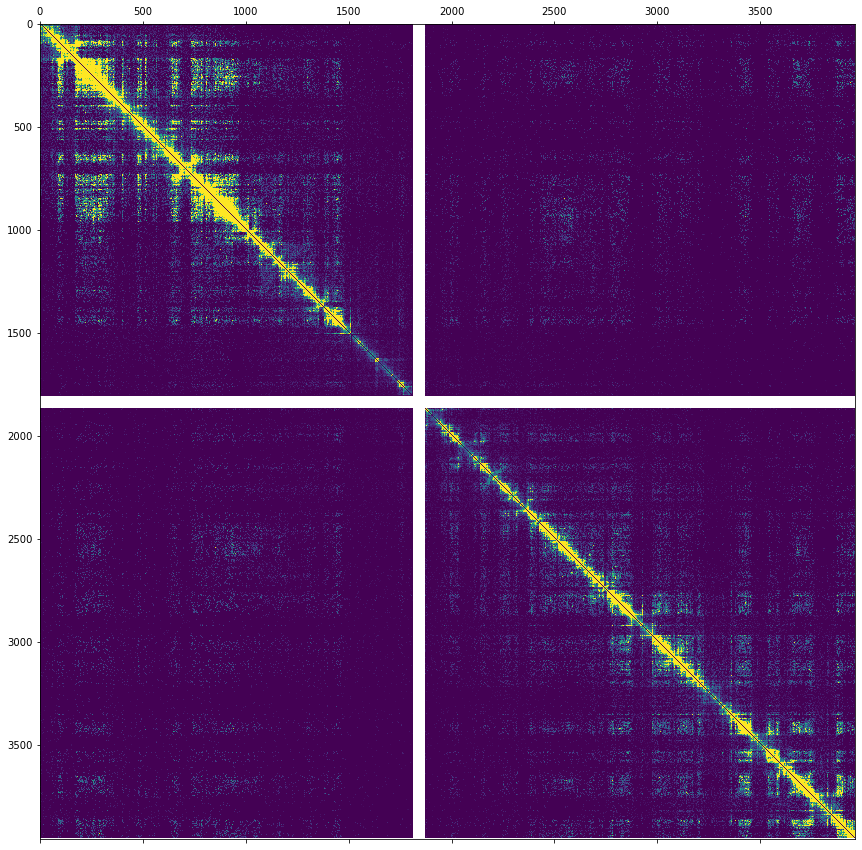

In [39]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(mat, vmax=10)
fig.show()

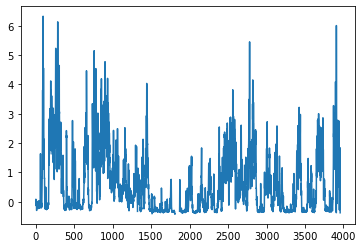

In [41]:
plt.plot(np.arange(cis_eigs[1].shape[1]), cis_eigs[1][0,:])
plt.show()

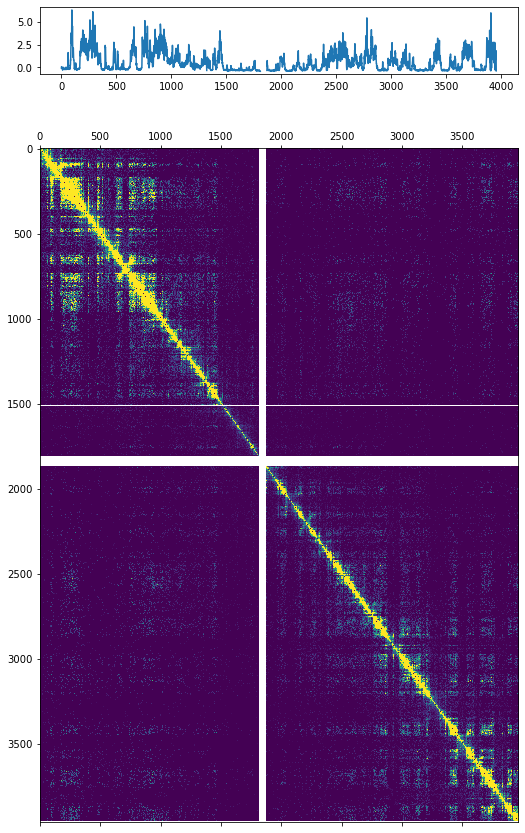

In [46]:
import matplotlib.gridspec as grd

plt.figure(figsize = (15, 15))
gs = grd.GridSpec(2, 2, height_ratios=[1,10], width_ratios=[6,1], wspace=1)
ax = plt.subplot(gs[2])
ax = ax.matshow(mat, aspect="auto", vmax=10)
ax2 = plt.subplot(gs[0])
ax2.plot(np.arange(cis_eigs[1].shape[1]), cis_eigs[1][0,:])
plt.show()

In [15]:
import fanc
import fanc.plotting as fancplot
import matplotlib.pyplot as plt